## With DQN replay memory (SGD optimizer)

In [1]:
import gym
import roboschool
from environment import Environment
from agent import Agent
from trainer import Final_variational_trainer, Q_learning_trainer
import matplotlib.pyplot as plt
import numpy as np
import math

**PLUS KL!!**

``loss_Q_var = torch.sum(0.5 * self.agent.PREC *  torch.pow(Q_var_pred_tf - sum_future_rewards_tf, 2) 
                       + 0.5 / self.agent.BETA * torch.pow(Q_var_pred_tf + loss_KL_tf_list.view((current_batch_size, 1) - Q_var_pred_tf.detach())
                                                  )``

**LAMBDA = 1 !!**

In [147]:
import json
from easydict import EasyDict
from datetime import date

# Environment Params

In [154]:
args = EasyDict()
args.ENV_NAME = 'BipedalWalker-v2' #'Pendulum-v0' #'CartPole-v1' #'MountainCar-v0' #'FrozenLake-v0' #

In [ ]:
env = gym.make(ENV_NAME)

# Trainer Params

In [155]:
args.monte_carlo=True
args.augmentation = True
args.final = False 

args.OBS_LEAK = 1e-3 
args.N_PART = 1000
args.KNN_prob=True

# Agent Params

In [163]:
args.isTime=False
args.offPolicy = False
ALPHA_REF = 1e-4
args.BETA = 100 
args.PREC = 1 
args.GAMMA=0.99 ######## !!!!!!!! ########
args.Q_VAR_MULT = 30
args.do_reward = True
args.HIST_HORIZON = 200 * int(1/OBS_LEAK)
args.N_HIDDEN = 300
args.optim = 'Adam'
args.ALPHA = ALPHA_REF / args.Q_VAR_MULT / args.PREC 
args.act_renorm = False
args.retain_present = True

# Data path

In [167]:
data_path = "{}-{}".format(str(date.today()),ENV_NAME)
if not args.final:
    data_path += '-full'
else:
    data_path += '-final'
if args.do_reward:
    data_path += '-do-reward'
else:
    data_path += '-no-reward'
data_path += '-{}'.format(args.optim)
data_path += '-LEAK-{}'.format(args.OBS_LEAK)
if args.KNN_prob:
    data_path += '-KNN'    
data_path += '-PART-{}'.format(args.N_PART)
data_path += '-HIDDEN-{}'.format(args.N_HIDDEN)
data_path += '-GAMMA-{}'.format(args.GAMMA)
data_path += '-BETA-{}'.format(args.BETA)
data_path += '-PREC-{}'.format(args.PREC)
if args.retain_present:
    data_path += '-retain'
data_path += '-ALPHA-{}'.format(ALPHA_REF)


In [171]:
data_path_npy = data_path+'.npy'
data_path_json = data_path+'.json'
data_path_Q_var = data_path+'Q_var.pt'

In [170]:
if not os.path.isfile(data_path_json):
    with open(data_path_json, 'w') as fp:
        json.dump(args, fp)

In [172]:
agent.get_time()

1600

In [5]:
N = 10

In [7]:
import time
import os

agent = Agent(env,
          ALPHA=args.ALPHA,
          BETA=args.BETA, 
          GAMMA=args.GAMMA, 
          PREC=args.PREC,
          do_reward=args.do_reward,
          Q_VAR_MULT=args.Q_VAR_MULT,
          isTime=args.isTime,    #!! TimeAgent
          offPolicy=args.offPolicy,
          HIST_HORIZON = args.HIST_HORIZON,
          optim=args.optim,
          N_HIDDEN=args.N_HIDDEN,
          act_renorm=args.act_renorm) 
    
trainer = Final_variational_trainer(agent, 
                                monte_carlo=args.monte_carlo, 
                                augmentation=args.augmentation,
                                final=args.final,
                                OBS_LEAK=args.OBS_LEAK,
                                ref_prob='unif',
                                N_PART=args.N_PART,
                                KNN_prob=args.KNN_prob)

if not os.path.isfile(data_path_npy):
   
    for i in range(N):
        trainer.run_episode()
        if trainer.nb_trials%10 ==0:
            print('***' + str(trainer.nb_trials) + '***')
            #print("Trajectory: ", trainer.trajectory)
            print("  Total reward got: %.4f" % trainer.total_reward)
            print("  #time steps : %d" % len(trainer.trajectory))
            print('  mean rtg:', np.mean(trainer.rtg_history))
    
            transitions = agent.memory.sample(2000)
            batch = Transition(*zip(*transitions))
            obs_sample = np.array(batch.obs)
            act_sample = np.array(batch.action)

            data = np.array((trainer.mem_total_reward, 
                             trainer.mem_t_final,
                             trainer.mem_mean_rtg,
                             obs_sample,
                             act_sample
                             ))
            np.save(data_path+'.npy', data)
            
            torch.save(agent.Q_var_nn, data_path_Q_var)
    
    
else:
    data = np.load(data_path_npy)
    mem_total_reward = data[0]
    mem_t_final = data[1]
    mem_mean_rtg = data[2]
    obs_sample = data[3]
    act_sample = data[4]
    
    agent.Q_var_nn  = torch.load(data_path_Q_var)


        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


BETA= 100 , PREC= 1
Elapsed time: 0.0001829999999998222
***10***
  Total reward got: -100.5316
  #time steps : 66
  mean rtg: -72.5448557430935
  TEST:
  Total reward got: -134.5389
  #time steps : 1601


In [ ]:
N=10000
for i in range(N):
        trainer.run_episode()
        #final_time = agent.get_time()
        #liste_rtg = np.zeros(final_time)
        #for time in range(final_time):
        #    liste_rtg[time] = np.sum(np.array(trainer.reward_history[time:]) * \
        #               agent.GAMMA **(np.arange(time, final_time) - time))
        #mem_rtg.append(np.mean(liste_rtg))    
        #mem_max_rtg.append(np.max(liste_rtg))   
        if trainer.nb_trials%10 ==0:
            #plt.figure(figsize = (4, 4))
            #plt.plot(agent.KL.flatten())
            print('***' + str(trainer.nb_trials) + '***')
            #print("Trajectory: ", trainer.trajectory)
            print("  Total reward got: %.4f" % trainer.total_reward)
            print("  #time steps : %d" % len(trainer.trajectory))
            print('  mean rtg:', np.mean(trainer.rtg_history))
            print('  TEST:')
            trainer.run_episode(train=False)
            #print("Trajectory: ", trainer.trajectory)
            print("  Total reward got: %.4f" % trainer.total_reward)
            print("  #time steps : %d" % len(trainer.trajectory))

***5850***
  Total reward got: 41.7476
  #time steps : 1601
  mean rtg: 2.7784030011456298
  TEST:
  Total reward got: -115.0703
  #time steps : 1601
***5860***
  Total reward got: 33.9007
  #time steps : 1601
  mean rtg: 1.9496824891846705
  TEST:
  Total reward got: -113.4482
  #time steps : 1601
***5870***
  Total reward got: 12.8443
  #time steps : 1601
  mean rtg: 0.9553293952635349
  TEST:
  Total reward got: -114.8812
  #time steps : 1601
***5880***
  Total reward got: 33.1302
  #time steps : 1601
  mean rtg: 2.1397642187415133
  TEST:
  Total reward got: -130.4178
  #time steps : 195
***5890***
  Total reward got: 68.8759
  #time steps : 1601
  mean rtg: 4.527808333021149
  TEST:
  Total reward got: -124.2117
  #time steps : 1601
***5900***
  Total reward got: 27.8656
  #time steps : 1601
  mean rtg: 1.6495243864982354
  TEST:
  Total reward got: -132.7910
  #time steps : 1601
***5910***
  Total reward got: 137.0115
  #time steps : 1601
  mean rtg: 8.651091348329722
  TEST:
  T

Text(0.5, 0, '# trials')

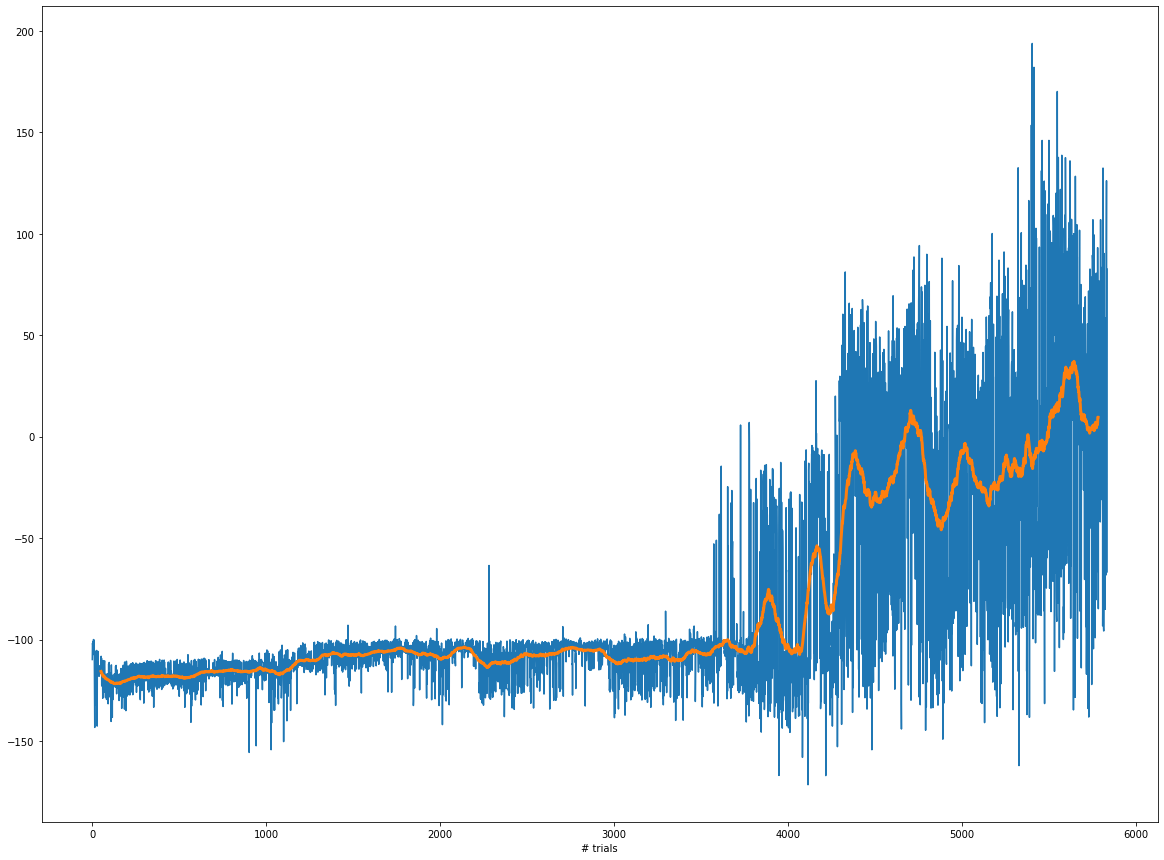

In [174]:
%matplotlib inline
N_eff = len(trainer.mem_total_reward)
plt.figure(figsize=(20,15))
plt.plot(trainer.mem_total_reward)
plt.plot(range(50,N_eff-51), np.convolve( trainer.mem_total_reward,np.ones(100)*1/100)[100:-100], linewidth=3)
#plt.plot(np.arange(10,N_eff,10), trainer.mem_total_reward_test,'rd')
plt.xlabel('# trials')

Text(0.5, 0, '# time steps')

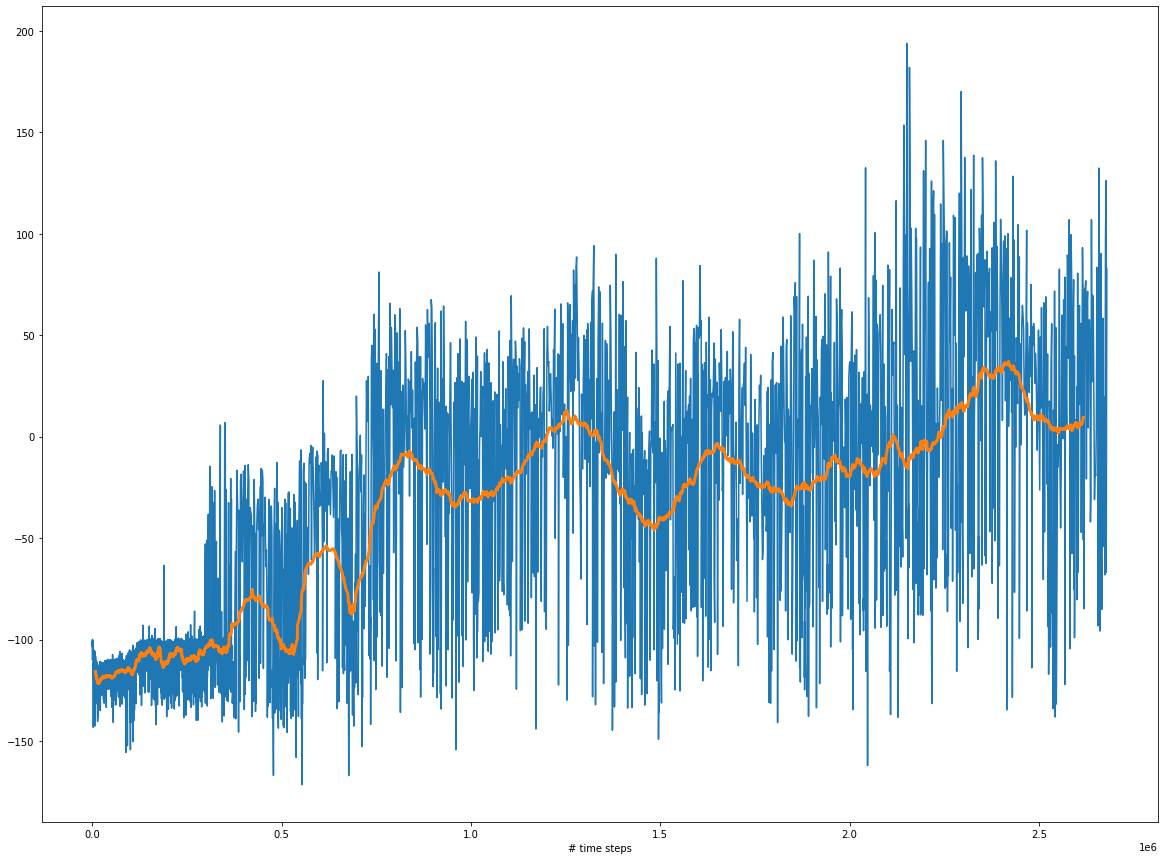

In [175]:
%matplotlib inline
N_eff = len(trainer.mem_total_reward)
plt.figure(figsize=(20,15))
axe_t = np.cumsum(trainer.mem_t_final)
plt.plot(axe_t,  trainer.mem_total_reward)
plt.plot(axe_t[range(50,N_eff-51)], np.convolve( trainer.mem_total_reward,np.ones(100)*1/100)[100:-100], linewidth=3)
#plt.plot(np.arange(10,N_eff,10), trainer.mem_total_reward_test,'rd')
plt.xlabel('# time steps')

In [ ]:
trainer.mem_total_reward

Text(0.5, 0, '# time steps')

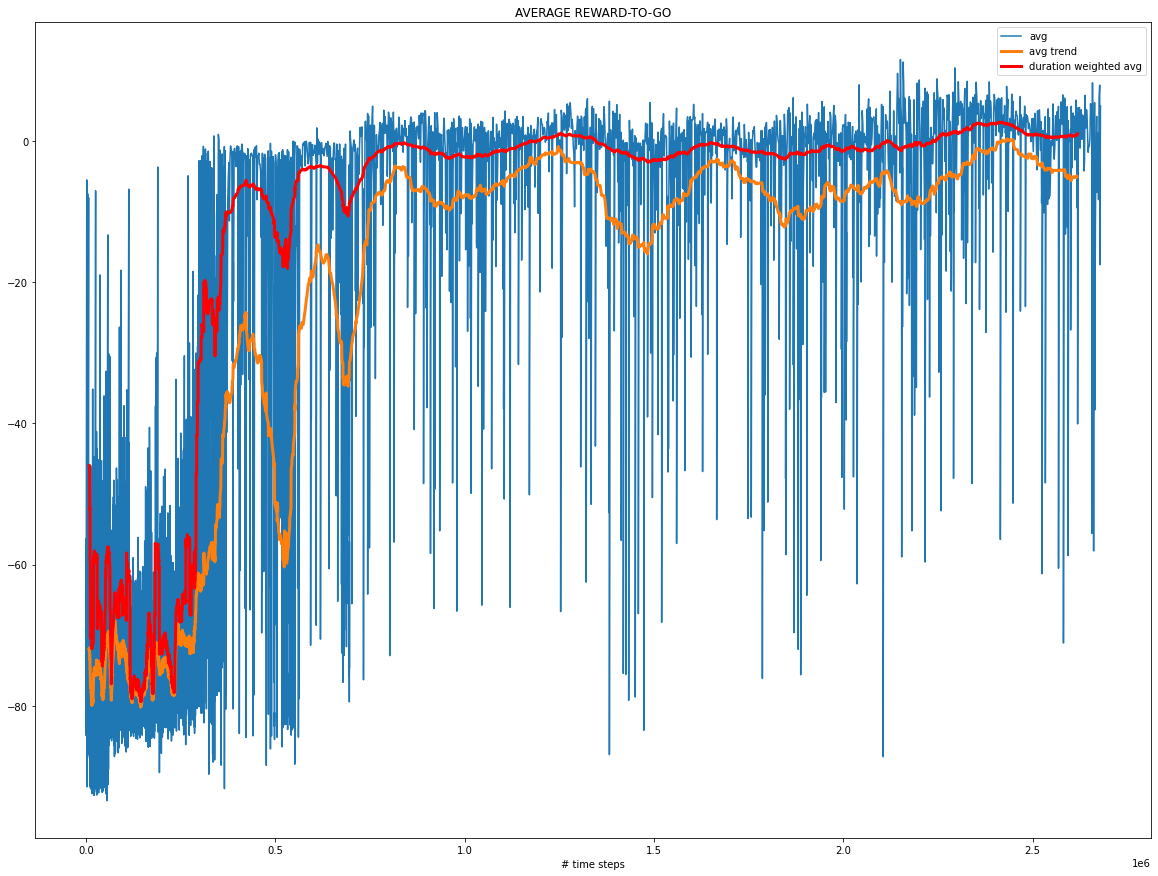

In [176]:
%matplotlib inline
N_eff = len(trainer.mem_mean_rtg)
plt.figure(figsize=(20,15))
plt.plot(axe_t,trainer.mem_mean_rtg, label= 'avg')
plt.plot(axe_t[range(50,N_eff-51)], np.convolve(trainer.mem_mean_rtg,np.ones(100)*1/100)[100:-100], linewidth=3, label = 'avg trend')
weighted_rtg = np.zeros(N_eff - 100)
for i in range(N_eff-100):
    weighted_rtg[i] = np.dot(trainer.mem_mean_rtg[i:i+100], trainer.mem_t_final[i:i+100]) / np.sum(trainer.mem_t_final[i:i+100])
plt.plot(axe_t[range(50,N_eff-50)], weighted_rtg, 'r', linewidth=3, label='duration weighted avg')
plt.legend()
plt.title('AVERAGE REWARD-TO-GO')
plt.xlabel('# time steps')

Text(0.5, 1.0, 'MEAN RTG :0.5832834')

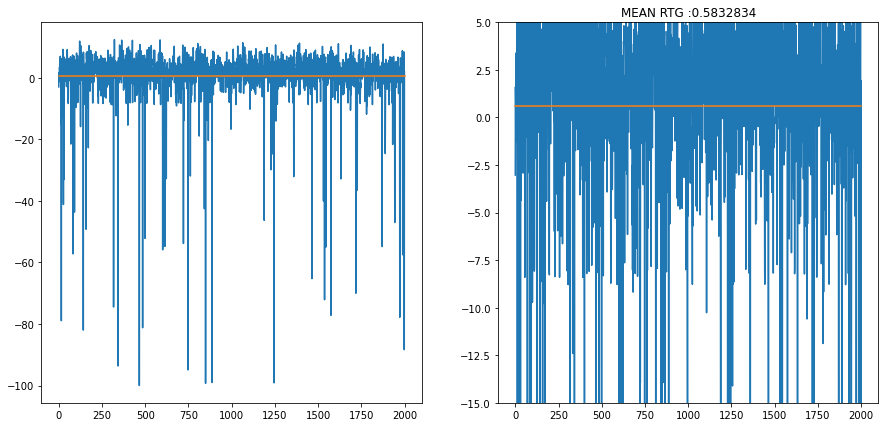

In [177]:
from agent import Transition
transitions = agent.memory.sample(2000)
batch = Transition(*zip(*transitions))
#obs = trainer.agent.get_observation()
sum_future_rewards_batch = np.array(batch.sum_future_rewards)
plt.figure(figsize=(15,7))
ax1=plt.subplot(1,2,1)
ax2=plt.subplot(1,2,2)
ax1.plot(sum_future_rewards_batch)
m = np.mean(sum_future_rewards_batch)
ax1.plot((1,2000),(m,m))
ax2.plot(sum_future_rewards_batch)
ax2.plot((1,2000),(m,m))
ax2.set_ylim(-15,5)
ax2.set_title('MEAN RTG :' + str(m))


#act_probs = trainer.agent.softmax(obs, actions_set=actions_set)
#act_probs

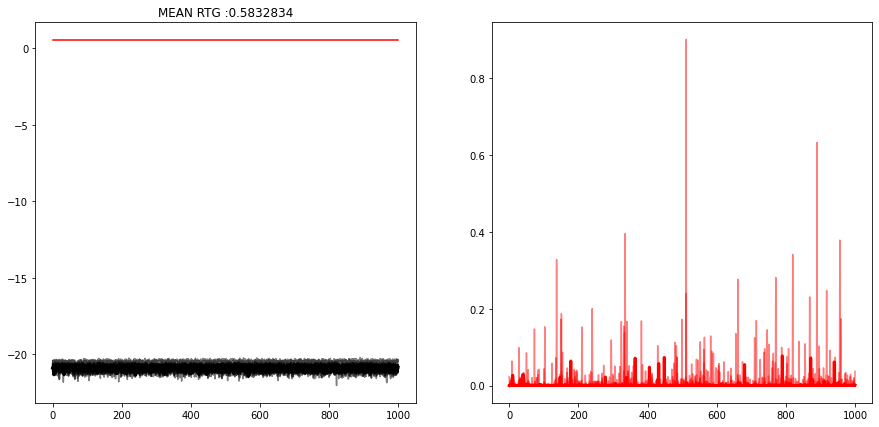

In [178]:
#obs = trainer.agent.get_observation()
transitions = agent.memory.sample(20)
batch = Transition(*zip(*transitions))
obs_batch = np.array(batch.obs)
plt.figure(figsize=(15,7))
ax1=plt.subplot(1,2,1)
ax2=plt.subplot(1,2,2)
for obs in obs_batch:
    actions_set = trainer.set_actions_set()
    #print(actions_set)
    Q_obs = trainer.agent.set_Q_obs(obs, actions_set = actions_set)
    ax1.plot(Q_obs,'k',alpha=.5)    
    ax1.set_title('MEAN RTG :' + str(m))
    ax2.plot(agent.softmax(obs, actions_set=actions_set), 'r', alpha=.5)
ax1.plot((1,trainer.N_PART), (m,m), 'r')
ax1.plot(Q_obs,'k',linewidth=3)
ax2.plot(agent.softmax(obs, actions_set=actions_set), 'r', linewidth=3)

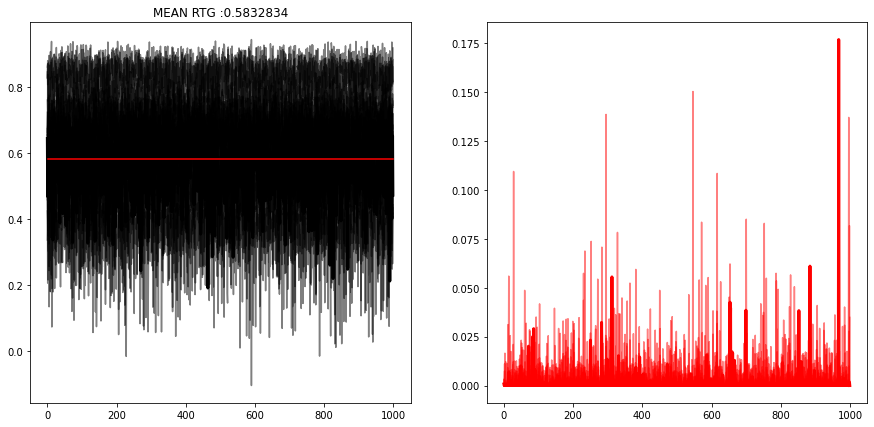

In [179]:
#obs = trainer.agent.get_observation()
transitions = agent.memory.sample(20)
batch = Transition(*zip(*transitions))
obs_batch = np.array(batch.obs)
plt.figure(figsize=(15,7))
ax1=plt.subplot(1,2,1)
ax2=plt.subplot(1,2,2)
for obs in obs_batch:
    actions_set = trainer.set_actions_set()
    #print(actions_set)
    Q_obs = trainer.agent.set_Q_obs(obs, Q=agent.Q_ref, actions_set = actions_set)
    ax1.plot(Q_obs,'k',alpha=.5)
    ax1.set_title('MEAN RTG :' + str(m))
    ax2.plot(agent.softmax(obs, Q=agent.Q_ref, actions_set=actions_set), 'r', alpha=.5)
ax1.plot(Q_obs,'k',linewidth=3)
ax1.plot((1,trainer.N_PART), (m,m), 'r')
ax2.plot(agent.softmax(obs, Q=agent.Q_ref, actions_set=actions_set), 'r', linewidth=3)

## Boucle 1

In [131]:
import time
from trainer import KNN_prob

final_time = agent.get_time()
liste_KL_test = np.zeros(final_time)
liste_KL_sample_3 = np.zeros(final_time)

state_probs = KNN_prob(np.array(trainer.mem_obs), k=1)

transitions = agent.memory.sample(20000)
batch = Transition(*zip(*transitions))

state_probs_sample =  KNN_prob(np.array(batch.obs)) #KNN_prob(np.array(trainer.mem_obs[::100]))
ref_probs = trainer.calc_ref_probs(obs)

tic = time.clock()
for t in range(final_time):
    new_obs = trainer.trajectory[t + 1]
    #print(trainer.state_probs(new_obs))
    test_done = final_time == t + 1
    liste_KL_test[t] = trainer.KL(new_obs, done=test_done)
    #liste_KL_sample_3[t] = max(np.log(state_probs_sample(new_obs)) - np.log(ref_probs), -100)
toc = time.clock()
print('elapsed time', toc-tic)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  app.launch_new_instance()


elapsed time 37.7620969999698


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [121]:
len(trainer.mem_obs)

200000

In [89]:
trainer.ref_probs

0.004434118983439232

In [105]:
agent.env.observation_space.high - agent.env.observation_space.low

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2.], dtype=float32)

In [90]:
trainer.state_probs(new_obs)

4245863227.627292

In [108]:
trainer.calc_ref_probs(new_obs*100)

0.004470492832469176

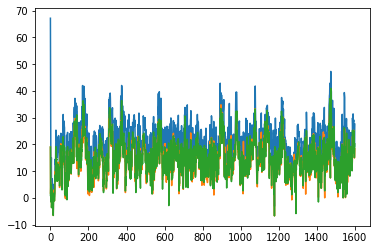

In [128]:
plt.plot(liste_KL)
plt.plot(liste_KL_sample)
plt.plot(liste_KL_sample_3)

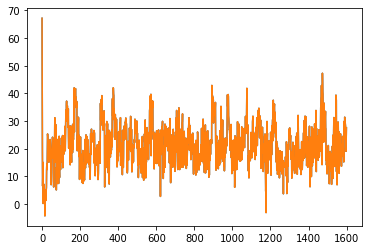

In [132]:
plt.plot(liste_KL)
plt.plot(liste_KL_test)


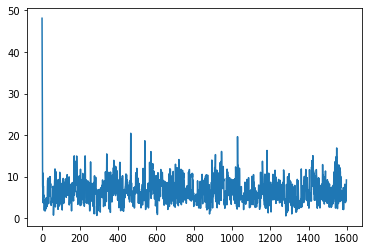

In [118]:
plt.plot(liste_KL-liste_KL_sample)

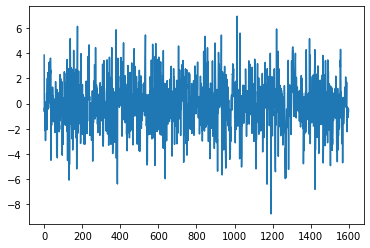

In [126]:
plt.plot(liste_KL_sample-liste_KL_sample_3)

In [143]:
for l in agent.Q_var_nn.fc2.parameters():
    print(l.data.shape)

torch.Size([1, 300])
torch.Size([1])


In [97]:
from trainer import KNN_prob

tic = time.clock()
state_probs = KNN_prob(np.array(trainer.mem_obs))
toc = time.clock()
print('elapsed time', toc-tic)

tic = time.clock()
ref_probs = trainer.calc_ref_probs(obs)
toc = time.clock()
print('elapsed time', toc-tic)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


elapsed time 0.151769999996759
elapsed time 0.3142200000002049


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.


In [110]:
high = np.max(trainer.mem_obs, axis = 0)
low = np.min(trainer.mem_obs, axis = 0)
high,low, 1/np.prod(high-low)

(array([2.36192036, 0.21957558, 0.64879114, 0.32613377, 1.1804316 ,
        1.79540598, 1.48738492, 2.56514311, 1.        , 1.27222347,
        2.13997459, 1.55520463, 3.40317408, 1.        , 0.52157444,
        0.52592105, 0.54165053, 0.58699012, 0.64199305, 0.72887278,
        0.87389088, 1.        , 1.        , 1.        ]),
 array([-2.871351  , -0.22107935, -0.46093274, -0.47352993, -0.9411341 ,
        -2.11461926, -0.88986826, -3.33856328,  0.        , -0.91127861,
        -2.23150611, -0.84311259, -3.22844346,  0.        ,  0.06687514,
         0.0679801 ,  0.07073747,  0.07549512,  0.08293575,  0.09467509,
         0.11332221,  0.1451764 ,  0.20099117,  0.33051243]),
 0.004470492832469176)

In [112]:
np.arange(100)[::10]

array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

## Log Softmax

In [192]:
actions_set

[array([ 0.13136438,  0.59142077,  0.71992517, -0.3504677 ], dtype=float32),
 array([-0.55706227, -0.83707696, -0.39347073, -0.08214708], dtype=float32),
 array([-0.03816191,  0.7317034 , -0.0614577 ,  0.9643468 ], dtype=float32),
 array([ 0.80315685, -0.9436421 ,  0.7362066 , -0.5004869 ], dtype=float32),
 array([ 0.7492991 ,  0.8846448 , -0.6797497 , -0.37067574], dtype=float32),
 array([-0.27324337,  0.4733499 , -0.8368531 ,  0.7361722 ], dtype=float32),
 array([ 0.5813055 ,  0.13896278, -0.7845392 , -0.7022022 ], dtype=float32),
 array([ 0.63000405, -0.5595483 , -0.60534   ,  0.4621716 ], dtype=float32),
 array([ 0.6467862 , -0.6648316 , -0.30178547,  0.32654348], dtype=float32),
 array([-0.7543222 , -0.2677498 , -0.91472995,  0.06442187], dtype=float32),
 array([-0.8157194 , -0.3797354 , -0.65364665,  0.3498031 ], dtype=float32),
 array([-0.26267064, -0.4890203 , -0.93089914,  0.4841795 ], dtype=float32),
 array([ 0.34583864, -0.6715953 , -0.4245239 ,  0.36481366], dtype=float32),

In [197]:
np.array(trainer.action_history).shape, np.array(trainer.actions_set_history).shape, np.array(trainer.trajectory).shape

((851, 4), (851, 1000, 4), (852, 24))

329
417
103
711
664
131
613
359
204
761
138
538
206
162
955
800
756
822


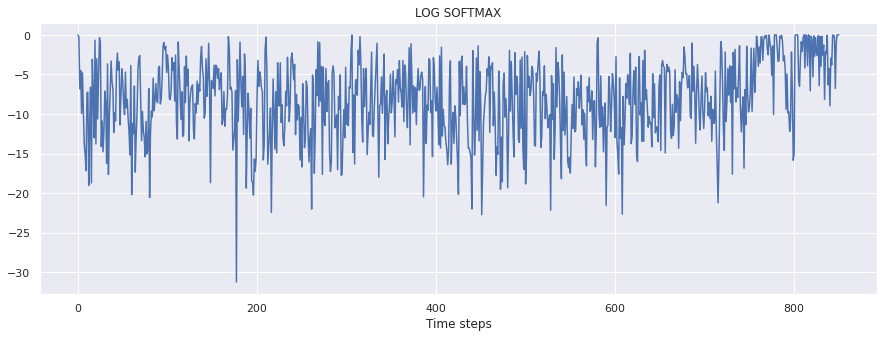

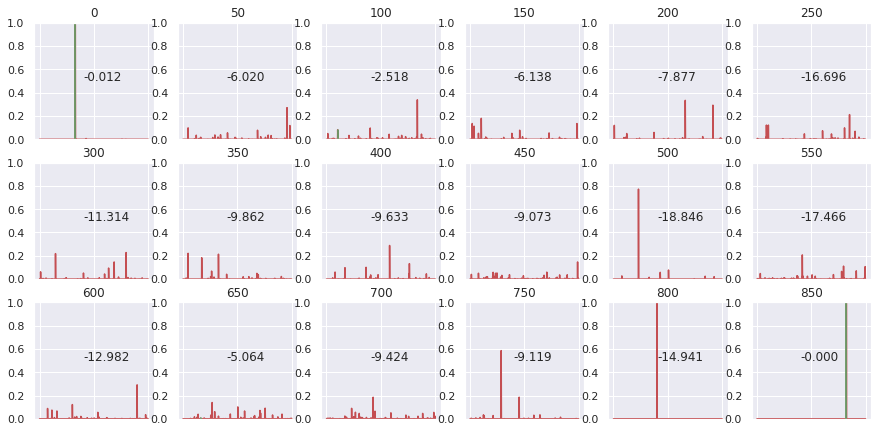

In [245]:
import seaborn
seaborn.set()

t = 809

liste_ls = []
liste_softmax = {}
for t in range(agent.get_time()):
    obs = trainer.trajectory[t]
    act = trainer.action_history[t]
    actions_set=trainer.actions_set_history[t]

    liste_ls += [agent.logSoftmax(obs, act, tf=False, actions_set=actions_set)]
    if t%50 == 0:
        liste_softmax[t] = agent.softmax(obs, Q=agent.Q_var, actions_set=actions_set)
    #plt.plot(agent.softmax(obs, Q=agent.Q_var, actions_set=actions_set), 'r', alpha=.5)

plt.figure(figsize=(15,5))
plt.plot(liste_ls)
plt.title('LOG SOFTMAX')
plt.xlabel('Time steps')

plt.figure(figsize=(15,15))

cpt=1
for t in liste_softmax.keys():
    ax = plt.subplot(6,6,cpt)
    ax.plot(liste_softmax[t], 'r')
    index_act = np.where(trainer.actions_set_history[t] == trainer.action_history[t])[0][0] 
    print(index_act)
    ax.plot((index_act, index_act), (0,liste_softmax[t][index_act]),'g')
    ax.set_ylim(0,1)
    ax.set_title(t)
    ax.text(400,0.5,'%.3f'%liste_ls[t])
    ax.set_xticklabels([])
    cpt += 1


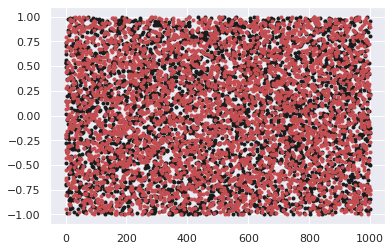

In [243]:
plt.plot(trainer.actions_set_history[t],'k.')
plt.plot(trainer.actions_set_history[t-1],'r.')

## test sauvegarde

In [183]:
data_path = "data/{}/{}-{}".format(ENV_NAME, str(date.today()), ENV_NAME)
if not args.final:
    data_path += '-full'
else:
    data_path += '-final'
if args.do_reward:
    data_path += '-do-reward'
else:
    data_path += '-no-reward'
data_path += '-{}'.format(args.optim)
data_path += '-LEAK-{}'.format(args.OBS_LEAK)
if args.KNN_prob:
    data_path += '-KNN'    
data_path += '-PART-{}'.format(args.N_PART)
data_path += '-HIDDEN-{}'.format(args.N_HIDDEN)
data_path += '-GAMMA-{}'.format(args.GAMMA)
data_path += '-BETA-{}'.format(args.BETA)
data_path += '-PREC-{}'.format(args.PREC)
if args.retain_present:
    data_path += '-retain'
data_path += '-ALPHA-{}'.format(ALPHA_REF)

data_path_npy = data_path+'.npy'
data_path_json = data_path+'.json'
data_path_Q_var = data_path+'Q_var.pt'

if not os.path.isfile(data_path_json):
    with open(data_path_json, 'w') as fp:
        json.dump(args, fp)

In [185]:
if not os.path.isfile(data_path_npy):
    transitions = agent.memory.sample(2000)
    batch = Transition(*zip(*transitions))
    obs_sample = np.array(batch.obs)
    act_sample = np.array(batch.action)

    data = np.array((trainer.mem_total_reward, 
                     trainer.mem_t_final,
                     trainer.mem_mean_rtg,
                     obs_sample,
                     act_sample
                     ))    
    
    np.save(data_path_npy, data)


In [187]:
import torch
if not os.path.isfile(data_path_Q_var):
    torch.save(agent.Q_var_nn, data_path_Q_var)

In [ ]:
tic=time.clock()
for time in range(trainer.final_time):
    new_obs = self.trajectory[time + 1]
    test_done = final_time == time + 1
    liste_KL[time] = self.KL(new_obs, done=test_done)

-125.60997895696639


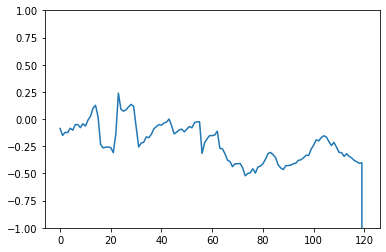

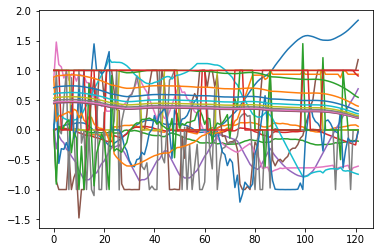

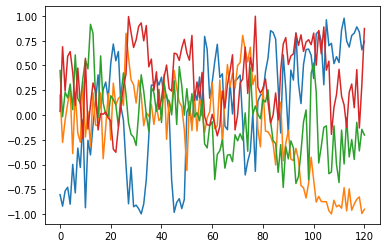

In [52]:
%matplotlib tk
agent.env=env
trainer.run_episode(render=True, train=False)
%matplotlib inline
plt.plot(trainer.reward_history)
plt.ylim(-1,1)
plt.figure()
plt.plot(trainer.trajectory)
print(trainer.total_reward)
plt.figure()
plt.plot(trainer.action_history)


-79.66304990768568


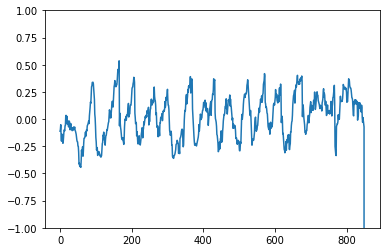

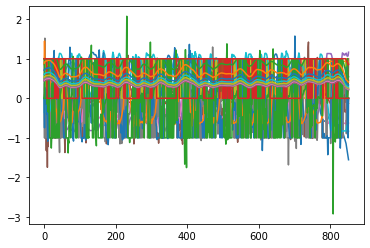

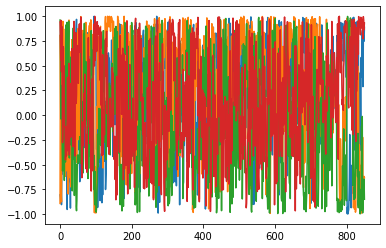

In [181]:
%matplotlib tk
agent.env=env
trainer.run_episode(render=True)
%matplotlib inline
plt.plot(trainer.reward_history)
plt.ylim(-1,1)
plt.figure()
plt.plot(trainer.trajectory)
print(trainer.total_reward)
plt.figure()
plt.plot(trainer.action_history)


In [ ]:
_ = plt.plot(trainer.mem_obs)

In [ ]:
_ = plt.plot(trainer.mem_act)

In [ ]:
len(trainer.mem_obs)

OK


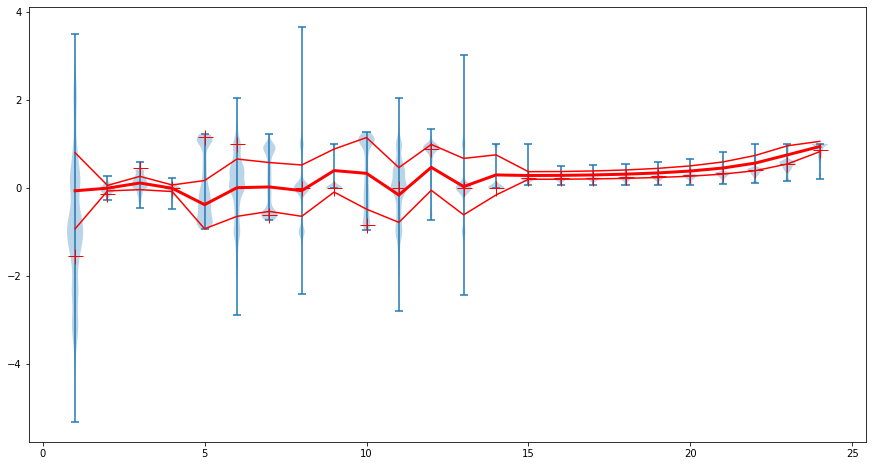

In [188]:
from scipy.stats import multivariate_normal

b_inf = min(trainer.HIST_HORIZON, len(trainer.mem_obs))
mem_obs = trainer.mem_obs
mem_obs_final = np.array(trainer.mem_obs_final)
mu = np.mean(mem_obs[-b_inf:], axis=0)
var = np.var(mem_obs[-b_inf:], axis=0)

print('OK')

plt.figure(figsize=(15,8))
fig = plt.violinplot(mem_obs_final)

b_inf = min(int(1/trainer.OBS_LEAK), len(trainer.mem_obs_final))
mu_final = np.mean(trainer.mem_obs_final[-b_inf:], axis=0)
var_final = np.var(trainer.mem_obs_final[-b_inf:], axis=0)
#rv = multivariate_normal(mu, var)
plt.plot(np.arange(len(mu_final))+1, mu_final, 'r', linewidth=3)
plt.plot(np.arange(len(mu_final))+1,mu_final+np.sqrt(var_final), 'r')
plt.plot(np.arange(len(mu_final))+1,mu_final-np.sqrt(var_final), 'r')

#rv = multivariate_normal(mu_final, var_final)
#for i in range(100):
#    plt.plot(np.arange(len(mu_final))+1, rv.rvs(),'.k', alpha=.1)
    
#rv = multivariate_normal(mu, var)
#for i in range(100):
#    plt.plot(np.arange(len(mu))+1, rv.rvs(),'.r', alpha=.1)
    
obs = trainer.trajectory[-1]
plt.plot(np.arange(len(mu_final))+1, obs,'r+', markersize=15)

OK


Text(0.5, 1.0, 'ACT')

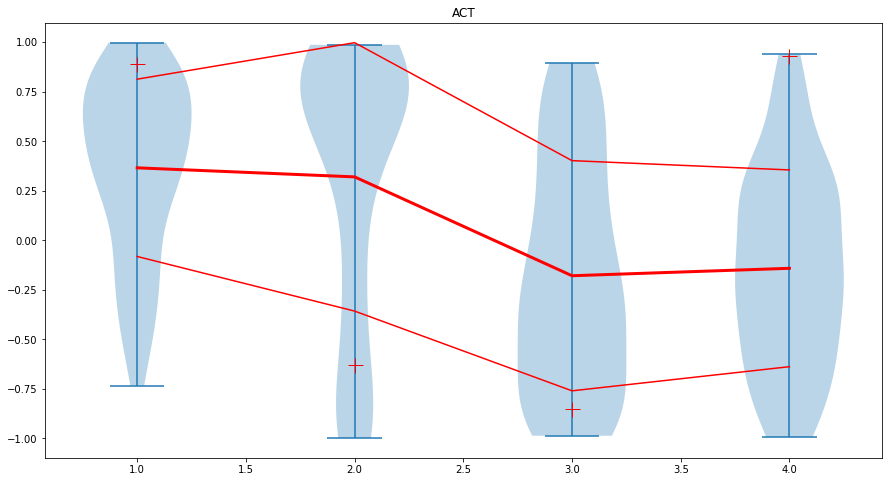

In [189]:
from scipy.stats import multivariate_normal

mem_act = np.array(trainer.mem_act[:100:])

b_inf = min(trainer.HIST_HORIZON, len(mem_act))
#mem_obs_final = np.array(trainer.mem_obs_final)
#mu = np.mean(mem_act[-b_inf:], axis=0)
#var = np.var(mem_act[-b_inf:], axis=0)

print('OK')

plt.figure(figsize=(15,8))
fig = plt.violinplot(mem_act)

b_inf = min(int(200/trainer.OBS_LEAK), len(mem_act))
mu_act = np.mean(mem_act[-b_inf:], axis=0)
var_act = np.var(mem_act[-b_inf:], axis=0)
#rv = multivariate_normal(mu, var)
plt.plot(np.arange(len(mu_act))+1, mu_act, 'r', linewidth=3)
plt.plot(np.arange(len(mu_act))+1,mu_act+np.sqrt(var_act), 'r')
plt.plot(np.arange(len(mu_act))+1,mu_act-np.sqrt(var_act), 'r')

#rv = multivariate_normal(mu_final, var_final)
#for i in range(100):
#    plt.plot(np.arange(len(mu_final))+1, rv.rvs(),'.k', alpha=.1)
    
#rv = multivariate_normal(mu, var)
#for i in range(100):
#    plt.plot(np.arange(len(mu))+1, rv.rvs(),'.r', alpha=.1)
    
act = trainer.action_history[-1]
plt.plot(np.arange(len(mu_act))+1, act,'r+', markersize=15)
plt.title('ACT')

1.2129306074584427
-6.173823788718676
7.3867543961771185


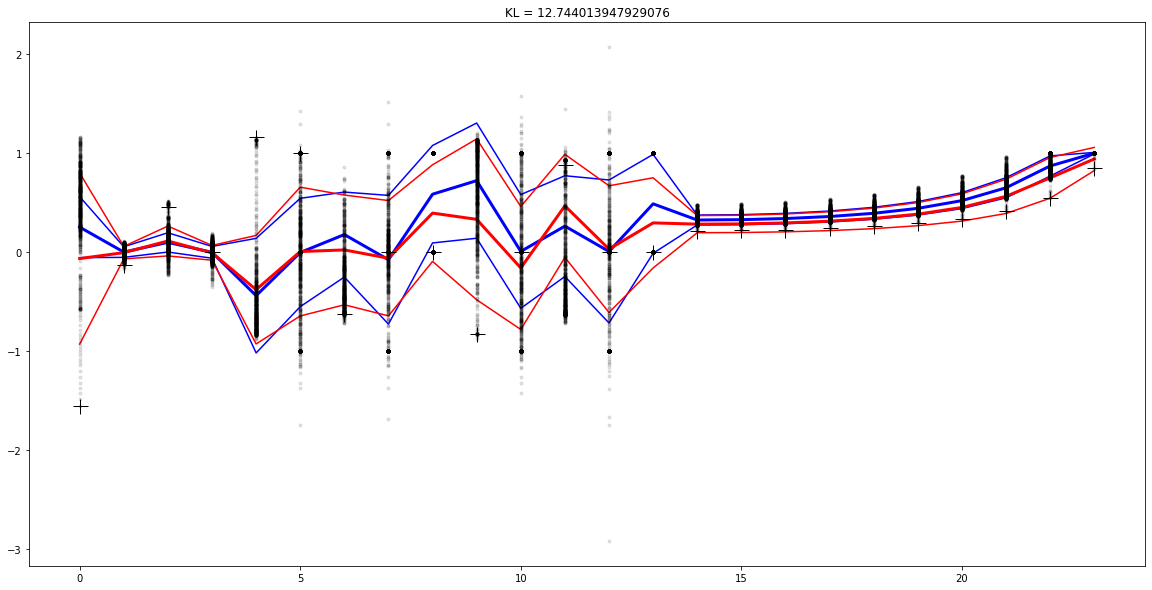

In [190]:
plt.figure(figsize=(20,10))
plt.plot(mu,'b', linewidth=3)
plt.plot(mu+np.sqrt(var),'b')
plt.plot(mu-np.sqrt(var),'b')
plt.plot(mu_final, 'r', linewidth=3)
plt.plot(mu_final+np.sqrt(var_final),'r')
plt.plot(mu_final-np.sqrt(var_final),'r')
plt.plot(obs,'+k', markersize=15)
_ = plt.plot(np.array(trainer.trajectory).T,'k.', alpha=.1)
plt.title('KL = ' + str(trainer.KL(trainer.mem_obs_final[-1], done=True)))
print(np.log(trainer.calc_final_state_probs()(obs)))
print(np.log(trainer.ref_probs))
print(np.log(trainer.calc_final_state_probs()(obs)) - np.log(trainer.ref_probs))

In [ ]:
plt.plot(trainer.action_history)

In [ ]:
mean_obs = np.zeros((len(BETA_range), len(PREC_range)))
mean_reward = np.zeros((len(BETA_range), len(PREC_range)))

for i, BETA in enumerate(BETA_range):
    for j, PREC in enumerate(PREC_range):
        mean_obs[i,j] = np.mean(mem_obs_final[BETA][PREC])
        mean_reward[i,j] = np.mean(mem_total_reward[BETA][PREC])
    
        

In [ ]:
#plt.imshow(mean_obs)
im = plt.imshow(mean_obs.T, 
              origin='lower', 
              extent=[min(BETA_range)-2.5, max(BETA_range)+2.5,
                      min(PREC_range)-5e-5, max(PREC_range)+5e-5],
              aspect = 'auto',
              alpha=1)
plt.colorbar(im)
plt.xlabel('BETA')
plt.ylabel('PREC')
plt.title('Mean final obs')


In [ ]:
im = plt.imshow(mean_reward.T, 
              origin='lower', 
              extent=[min(BETA_range)-2.5, max(BETA_range)+2.5,
                      min(PREC_range)-5e-5, max(PREC_range)+5e-5],
              aspect = 'auto',
              alpha=1)
plt.colorbar(im)
plt.xlabel('BETA')
plt.ylabel('PREC')
plt.title('Mean reward')

In [ ]:


#BETA = 30
#PREC = 0.0009
plt.figure(figsize=(20,15))
plt.plot(np.array(mem_obs_final[BETA][PREC])[:,:])

In [ ]:
plt.figure(figsize = (20,20))
for i, BETA in enumerate(BETA_range):
    for j, PREC in enumerate(PREC_range):
        plt.subplot(10,10,i*10+j+1)
        plt.plot(np.array(mem_obs_final[BETA][PREC])[:,0])
        if i < 9:
            plt.xticks([])
        else:
            plt.xlabel('PREC='+str(PREC))
        plt.ylim([-1.1,0.6])
        if j > 0:
            plt.yticks()
        else:
            plt.ylabel('BETA='+str(BETA))

In [ ]:
obs = agent.get_observation()
obs

In [ ]:
trainer.final

In [ ]:
np.concatenate((obs, agent.one_hot(1)))

In [ ]:
agent.Q_KL(obs,0, tf=True)

In [ ]:
agent.softmax_choice([0, 0, 0, 0])

In [ ]:
m = (agent.env.observation_space.high + agent.env.observation_space.low) / 2
m

In [ ]:
agent.env.observation_space.high

In [ ]:
agent.env.observation_space.low

In [ ]:
from scipy.stats import multivariate_normal
test = np.array(trainer.mem_obs_final).T
mu = np.mean(test, axis = 1)
Sigma = np.cov(np.array(trainer.mem_obs_final).T)
rv = multivariate_normal(mu, Sigma)

In [ ]:
plt.figure(figsize=(20,15))
plt.plot(np.array(trainer.mem_obs_final)[:,:2])

In [ ]:
trainer.action_history

In [ ]:
trainer.agent.softmax(trainer.agent.get_observation())

In [ ]:
obs = (0,0,0) #trainer.agent.get_observation()

In [ ]:
trainer.agent.set_Q_obs(obs, Q = agent.Q_KL)

In [ ]:
trainer.agent.set_Q_obs(obs, Q = agent.Q_var)

In [ ]:
trainer.Q_learning

In [ ]:
agent.N_act

In [ ]:
%matplotlib inline
import time
import seaborn
seaborn.set()
axe = np.arange(-100,100)/100

p_ref = 1 / np.prod(agent.env.observation_space.high - agent.env.observation_space.low)

f={}
KL={}
pred_KL={}
pred_reward={}
pred_var={}
act = {}
for v in [-0.01, 0.0, 0.01]:
    f[v] = np.zeros(200)
    KL[v] = np.zeros(200)
    pred_KL[v] = np.zeros(200)
    pred_reward[v] = np.zeros(200)
    pred_var[v] = np.zeros(200)
    act[v] = []
    for a in range(agent.N_act):
        act[v].append(np.zeros(200))

for i in range(200):
    for v in [-0.01, 0.0, 0.01]:
        obs = (axe[i], v, 0)
        tic_1 = time.clock()
        f[v][i] = rv.pdf(obs)
        tic_2 = time.clock()
        KL[v][i] = np.log(f[v][i]) - np.log(p_ref)
        tic_3 = time.clock()
        #pred_KL[i] = trainer.calc_sum_future_KL(obs, obs, done=False)
        sum_future_KL = trainer.KL(obs, done=False)
        tic_3_1 = time.clock()
        next_values = agent.set_Q_obs(obs, Q=agent.Q_KL)
        tic_3_2 = time.clock()
        next_sum = agent.softmax_expectation(obs, next_values)
        tic_3_3 = time.clock()
        pred_KL[v][i] += agent.GAMMA * next_sum
        
        tic_4 = time.clock()   
        pred_reward[v][i] = trainer.calc_sum_future_rewards(0, obs, done=False)
        tic_5 = time.clock()   
        pred_var[v][i] = trainer.agent.softmax_expectation(obs, trainer.agent.set_Q_obs(obs))
        tic_6 = time.clock()   
        if i ==0:
            print('rv.pdf(obs)',
                 (tic_2-tic_1)*1000)
            print('np.log(f[i]) - np.log(p_ref)',
                  (tic_3-tic_2)*1000)
            print('trainer.calc_sum_future_KL(obs, obs, done=False)',
                  (tic_4-tic_3)*1000)
            print('sum_future_KL = trainer.KL(obs, done=False)',
                  (tic_3_1-tic_3)*1000)
            print('next_values = agent.set_Q_obs(obs, Q=agent.Q_KL)',
                  (tic_3_2-tic_3_1)*1000)
            print('next_sum = agent.softmax_expectation(obs, next_values)',
                  (tic_3_3-tic_3_2)*1000)
            print('trainer.calc_sum_future_rewards(0, obs, done=False)',
                  (tic_5-tic_4)*1000)
            print('trainer.agent.softmax_expectation(obs, trainer.agent.set_Q_obs(obs))',
                  (tic_6-tic_5)*1000)
        for a in range(agent.N_act):
            act[v][a][i] = trainer.agent.Q_var(obs,a)
       
for v in [-0.01, 0.0, 0.01]:
    plt.plot(axe, f[v], label=v)
plt.plot((-1, 1), (p_ref, p_ref))
plt.plot([-0.5, -0.5],[0, 400],'r--')
plt.legend()
#plt.title()
plt.figure()
for v in [-0.01, 0.0, 0.01]:
    plt.plot(axe, KL[v], label='instant KL ('+str(v)+')')
plt.plot((-1, 1), (0, 0))
plt.plot([-0.5, -0.5],[-400, 400],'r--')
plt.ylim((-10,10))
plt.legend()
plt.figure()
for v in [-0.01, 0.0, 0.01]:
    plt.plot(axe, pred_KL[v], label='sum future KL ('+str(v)+')')
plt.plot([-0.5, -0.5],[-400, 400],'r--')
plt.ylim((-10,10))
#plt.ylim([-1, 5])
plt.legend()
plt.figure()
for v in [-0.01, 0.0, 0.01]:
    plt.plot(axe, pred_reward[v], label='sum future rewards ('+str(v)+')')
    plt.plot(axe, pred_var[v], label='softmax value ('+str(v)+')')
plt.plot([-0.5, -0.5],[-1, 1],'r--')
plt.legend()
plt.figure()
for a in range(agent.N_act):
    plt.plot(axe, act[-0.01][a], label='act '+str(a))
plt.plot([-0.5, -0.5],[-1, 1],'r--')
plt.title(-0.01)
plt.legend()
plt.figure()
for a in range(agent.N_act):
    plt.plot(axe, act[0.][a], label='act '+str(a))
plt.plot([-0.5, -0.5],[-1, 1],'r--')
plt.title(0.0)
plt.legend()
plt.figure()
for a in range(agent.N_act):
    plt.plot(axe, act[0.01][a], label='act '+str(a))
plt.plot([-0.5, -0.5],[-1, 1],'r--')
plt.title(0.01)
plt.legend()

In [ ]:
%matplotlib inline
plt.plot(trainer.mem_total_reward)

In [ ]:
%matplotlib tk
agent.env=env
trainer.run_episode(render=True)
plt.plot(trainer.trajectory)
print(trainer.total_reward)

In [ ]:
trainer.action_history

In [ ]:
%matplotlib inline
data_obs = np.array(trainer.mem_obs)
r = len(trainer.mem_obs) // 20
plt.figure(figsize=(20,15))
for inter in range(20):
    b_min = r *inter
    b_max = b_min + r
    mu = np.mean(data_obs[b_min:b_max,:].T, axis = 1)
    Sigma = np.cov(data_obs[b_min:b_max,:].T)
    rv = multivariate_normal(mu, Sigma)
    axe_0 = np.linspace(-1.3, 0.5, 101)
    axe_1 = np.linspace(-0.1, 0.1, 101)
    proba = np.zeros((101, 101))
    for i, x in enumerate(axe_0):
        for j, y in enumerate(axe_1):
            obs = (x, y, 0, 0)
            proba[i,j] = rv.pdf(obs)
    ax = plt.subplot(5,4,inter+1)
    ax.imshow(proba.T, 
              origin='lower', 
              extent=[-1.3,
                       0.5, 
                       -0.1,
                       0.1],
              aspect = 'auto')
    #plt.colorbar()
    #ax = plt.subplot(5,4,inter+2)
    ax.plot(data_obs[b_min:b_max,0], data_obs[b_min:b_max,1], '.r', markersize= 1, alpha = .1)
    plt.xlim((-1.3,0.5))
    plt.ylim((-0.1,0.1))
    

In [ ]:
np.array(1).ndim

In [ ]:
int(1/0.1)

In [ ]:
np.mean(trainer.mem_obs[-1000:], axis = 0)